In [1]:
%matplotlib inline
import time 
from qutip import mesolve, steadystate
import numpy as np
import optical as EM
import phonons as RC
import leads as FL
from utils import *
from photocell_setup import *
import matplotlib.pyplot as plt
from importlib import reload
from style import *

utils imported


In [2]:
def short_current(v,c):
    # assumes that V=0 at element 0
    return c[0]

def estimate_Voc(v, c):
    # voltage where current goes to zero
    return v[np.argmin(np.abs(c))]

def power_values(v, c):
    return np.array(v)*np.array(c)

def power_values_from_dict(_data_dict):
    return np.array(_data_dict['bias_voltages'])*np.array(_data_dict['current'])

def max_power(v, c):
    # can make this more sophisticated at a later date
    return np.max(power_values(v, c))

def theoretical_max_power(v,c):
    return short_current(v,c)*estimate_Voc(v, c)

def fill_factor(v, c):
    return max_power(v, c)/theoretical_max_power(v,c)

def fill_factor_from_dict(_data_dict):
    return fill_factor(_data_dict['bias_voltages'], _data_dict['current'])

def voltage_at_max_power_from_dict(_data_dict):
    return _data_dict['bias_voltages'][np.argmax(power_values_from_dict(_data_dict))]

def plot_power(_data_dict):
    current = _data_dict['current']
    
    voltage = _data_dict['bias_voltages']*ev_to_inv_cm
    power = power_values(voltage, current)
    plt.plot(voltage, power)
    plt.axvline(estimate_Voc(voltage, current))
    plt.axhline(max_power(power))

def get_photovoltaic_summary(data_dict):
    v, c = data_dict['bias_voltages'], data_dict['current']
    return {"fill_factor": fill_factor_from_dict(data_dict), 
         "V_OC" : estimate_Voc(v, c),
         "I_SC" : short_current(v, c),
         "P_max": max_power(data_dict['bias_voltages'], data_dict['current']),
         "P_theoretical_max": theoretical_max_power(v,c),
         "V_at_max_P": voltage_at_max_power_from_dict(data_dict)
        }

In [3]:
def convergence(PARAMS, N_lim=[5,18]):
    for N in range(N_lim[0],N_lim[-1]):
        PARAMS.update({'N': N})
        L_Lindblad_dict = build_L(PARAMS, silent=True)
        ss = steadystate(L_Lindblad_dict['H_S'], [L_Lindblad_dict['L']])

In [4]:
def populations_and_current_vs_voltage(PARAMS, x_range=[0,2], num_voltages=100):
    ti = time.time()
    if PARAMS['T_L']<100:
        number_of_voltages = int(1.8*num_voltages)
    else:
        number_of_voltages = num_voltages
    #bias_voltages = np. linspace(x_range[0]*ev_to_inv_cm, x_range[1]*ev_to_inv_cm, number_of_voltages)
    bias_voltages = np.concatenate((np.array([0]), 
                    np.linspace(x_range[0]*ev_to_inv_cm, x_range[1]*ev_to_inv_cm, number_of_voltages)), 
                                   axis=0)
    current = []
    conduction_population = []
    valence_population = []
    ground_population = []
    hole_population = []
    electron_population = []
    exciton_population = []
    CC_population = []
    ops = make_expectation_operators(PARAMS)
    for i, bv in enumerate(bias_voltages):
        PARAMS.update({'mu_R': PARAMS['mu']+bv/2, 'mu_L': PARAMS['mu']-bv/2})
        #if i in [10, 90]:
        #    print_PARAMS(PARAMS)
        L_Lindblad_dict = build_L(PARAMS, silent=True)
        #ops = make_expectation_operators(PARAMS)
        n_c = tensor(d_e.dag()*d_e, qeye(PARAMS['N']))
        n_v = tensor(d_h.dag()*d_h, qeye(PARAMS['N']))
        ss = steadystate(L_Lindblad_dict['H_S'], [L_Lindblad_dict['L']])
        current.append(current_from_ss(ss, L_Lindblad_dict['L_R'], n_c))
        conduction_population.append((n_c*ss).tr())
        valence_population.append((n_v*ss).tr())
        ground_population.append((ops['vac']*ss).tr())
        hole_population.append((ops['hole']*ss).tr())
        electron_population.append((ops['electron']*ss).tr())
        exciton_population.append((ops['exciton']*ss).tr())
        CC_population.append((ops['CC_pop']*ss).tr())
    bias_voltages/=ev_to_inv_cm
    data_dict = {'bias_voltages':bias_voltages, 
                 'current': current,
                 'conduction_population' : conduction_population, 
                 'valence_population' : valence_population,
                 'ground_population': ground_population,
                 'hole_population' : hole_population,
                 'electron_population' : electron_population,
                 'exciton_population' : exciton_population,
                 'CC_population' : CC_population,
                'PARAMS': PARAMS}
    print("C-V data calculated in {:0.1f} seconds".format(time.time() - ti))
    return data_dict



In [5]:
def plot_voltage_current(data_dict, label='', plot_CC=False):
    # if 
    _PARAMS = data_dict['PARAMS']
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10), sharex=True)
    
    X = data_dict['bias_voltages']
    red_mu_R, red_mu_L = _PARAMS['omega_c'], 2*_PARAMS['mu']-_PARAMS['omega_c']
    blue_mu_R  = 2*_PARAMS['mu']+(_PARAMS['omega_v']-_PARAMS['binding_energy'])
    blue_mu_L = -(_PARAMS['omega_v']-_PARAMS['binding_energy'])
    
    
    if abs(_PARAMS['binding_energy'])>0:
        yellow_mu_R = _PARAMS['omega_c']-_PARAMS['binding_energy']
        yellow_mu_L = 2*_PARAMS['mu']-(_PARAMS['omega_c']-_PARAMS['binding_energy'])
        yellow_mu_R/= ev_to_inv_cm
        yellow_mu_L/= ev_to_inv_cm
        ax2.axvline(yellow_mu_R - yellow_mu_L, linestyle='dotted', color=colors[5], linewidth=2.2)
        if _PARAMS['mu']<(_PARAMS['bandgap']/2):
            red_mu_R = 2*_PARAMS['mu']+_PARAMS['omega_v']
            red_mu_L = 2*_PARAMS['mu']-(red_mu_R)
    red_mu_R /= ev_to_inv_cm
    red_mu_L /= ev_to_inv_cm
    blue_mu_R/= ev_to_inv_cm
    blue_mu_L/= ev_to_inv_cm
    
    
    
    ax2.axvline(blue_mu_R-blue_mu_L, linestyle='dotted', color=colors[1], linewidth=2)
    ax2.axvline(red_mu_R-red_mu_L, linestyle='dotted', color=colors[0], linewidth=2)
    if plot_CC:
        ax1.plot(X, np.array(data_dict['CC_population']).real, label=r'$n_{CC}$')
    else:
        ax1.plot(X, np.array(data_dict['electron_population']).real, label=r'$n_e$')
        ax1.plot(X, np.array(data_dict['hole_population']).real, label=r'$n_h$')
        ax1.plot(X, np.array(data_dict['exciton_population']).real, label=r'$n_x$')
    
    
    ax2.set_xlabel('Bias voltage (eV)')
    ax1.set_ylabel('Population')
    ax2.set_ylabel('Current')
    #ax1.plot(X, np.array(data_dict['ground_population']).real, label=r'v')
    #ax1.plot(X, np.array(data_dict['hole_population']).real, label=r'h')
    #ax1.plot(X, np.array(data_dict['electron_population']).real, label=r'e')
    #ax1.plot(X, np.array(data_dict['exciton_population']).real, label=r'exc')
    ax1.set_xlim(X[0],X[-1])
    ax1.legend()
    plt.subplots_adjust(left=0.18, bottom=0.065, right=0.97, top=0.98, wspace=0.24, hspace=0.015)
    q = 1.602176634e-19 # coulomb
    current = np.array(data_dict['current']).real # in electrons per second?
    ax2.plot(X, current)
    plt_title = "PLOTS/C-V-{}.pdf".format(label)
    plt.savefig(plt_title)
    print("saved at "+plt_title)

# No binding energy

In [ ]:
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.0, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

data_dict_no_BE_1 = populations_and_current_vs_voltage(PARAMS)
plot_voltage_current(data_dict_no_BE_1, label='center-0meV')

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.0, radiative_lifetime=1, alpha_ph=0, mu=800e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

data_dict_no_BE_2 = populations_and_current_vs_voltage(PARAMS)
plot_voltage_current(data_dict_no_BE_2, label='above-0meV')

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.0, radiative_lifetime=1, alpha_ph=0, mu=600e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

data_dict_no_BE_3 = populations_and_current_vs_voltage(PARAMS)
plot_voltage_current(data_dict_no_BE_3, label='below-0meV')

# Small binding energy

In [ ]:
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.1, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

data_dict_100_1 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_100_1, label='center-100meV')

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.1, radiative_lifetime=1, alpha_ph=0, mu=800e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

#data_dict_100_2 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
#plot_voltage_current(data_dict_100_2, label='above-100meV')

#PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.1, radiative_lifetime=1, alpha_ph=0, mu=600e-3,
#                      bias_voltage=0, N=2, silent=False, T_C=77.)

#data_dict_100_3 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
#plot_voltage_current(data_dict_100_3, label='below-100meV')

exciton populations go to zero when $U=\omega_h$

In [ ]:
print_PARAMS(PARAMS)

# Medium binding energy

In [ ]:
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.2, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

data_dict_200_1 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_200_1, label='center-200meV')
"""
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.2, radiative_lifetime=1, alpha_ph=0, mu=800e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

data_dict_200_2 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_200_2, label='above-200meV')

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.2, radiative_lifetime=1, alpha_ph=0, mu=600e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

data_dict_200_3 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_200_3, label='below-200meV')"""

In [ ]:
plt.plot(data_dict_200_1['bias_voltages'], data_dict_200_1['exciton_population'], label='exc')
plt.plot(data_dict_200_1['bias_voltages'], data_dict_200_1['electron_population'], label='e')
plt.plot(data_dict_200_1['bias_voltages'], data_dict_200_1['hole_population'], label='h')
plt.legend()

In [ ]:
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.3, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

data_dict_300_1 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_300_1, label='center-300meV')

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.3, radiative_lifetime=1, alpha_ph=0, mu=800e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

data_dict_300_2 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_300_2, label='above-300meV')

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.3, radiative_lifetime=1, alpha_ph=0, mu=600e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

data_dict_300_3 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3)
plot_voltage_current(data_dict_300_3, label='below-300meV')

In [ ]:
data_dict_100_ph1.keys()

In [ ]:
plt.plot(data_dict_100_ph1['bias_voltages'], data_dict_100_ph1['exciton_population'])
plt.plot(data_dict_100_ph1['bias_voltages'], data_dict_100_ph1['electron_population'])
plt.plot(data_dict_100_ph1['bias_voltages'], data_dict_100_ph1['hole_population'])

## Analytical results

In [ ]:
def CS_analytical_current(PARAMS):
    Gamma_Ldown, Gamma_Lup, Gamma_Rdown, Gamma_Rup = FL.leads_rates(PARAMS)
    Gamma_downEM, Gamma_upEM = EM.EM_rates(PARAMS)
    Gamma_downEM*=2
    Gamma_upEM*=2
    
    numer = 2*(Gamma_Ldown+Gamma_Lup+Gamma_Rdown+Gamma_Rup)
    numer*=(Gamma_downEM*Gamma_Ldown*Gamma_Rup-Gamma_Lup*Gamma_Rdown*Gamma_upEM)
    denom = (Gamma_Ldown+Gamma_Lup)*(Gamma_Rdown+Gamma_Rup)*(Gamma_Ldown+Gamma_Lup+Gamma_Rdown+Gamma_Rup)
    denom += Gamma_downEM*(Gamma_Ldown**2+(Gamma_Rup+Gamma_Lup)*(Gamma_Rdown+Gamma_Rup)+Gamma_Ldown*(Gamma_Lup+Gamma_Rdown+Gamma_Rup))
    denom += (Gamma_Lup**2+Gamma_Lup*(Gamma_Rdown+Gamma_Rup)+Gamma_Rdown*(Gamma_Rdown+Gamma_Rup)+Gamma_Ldown*(Gamma_Lup+Gamma_Rdown+Gamma_Rup))*Gamma_upEM
    return -numer/denom

def rate_analytical_current():
    numer = Gamma_downalpha*Gamma_downbeta*Gamma_downI*Gamma_upEM
    numer-= Gamma_downEM*Gamma_upalpha*Gamma_upbeta*Gamma_upI
    denom = (Gamma_downI+Gamma_upalpha)*(Gamma_downEM*Gamma_upbeta + Gamma_downbeta*(Gamma_downEM+Gamma_upEM))
    denom = Gamma_downEM*(Gamma_upalpha+Gamma_upbeta)
    #nenom = Gamma_downalpha*Gamma_downbeta*Gamma_downI+Gamma_upEM+(Gamma_downI+Gamma_upI) (\Gamma _{\text{upC$\beta $}}+\Gamma _{\text{upEM}}\right)\right)+\left(\Gamma _{\text{downI}}+\Gamma _{\text{upC$\alpha $}}\right) \left(\Gamma _{\text{downC$\beta $}} \left(\Gamma _{\text{downEM}}+\Gamma _{\text{upEM}}\right)+\Gamma _{\text{downEM}} \Gamma _{\text{upC$\beta $}}\right)+\Gamma _{\text{upI}} \left(\Gamma _{\text{downEM}} \left(\Gamma _{\text{upC$\alpha $}}+\Gamma _{\text{upC$\beta $}}\right)+\Gamma _{\text{upC$\alpha $}} \left(\Gamma _{\text{upC$\beta $}}+\Gamma _{\text{upEM}}\right)\right)}

PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.0, radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=2, N=2, silent=False, T_C=77.)
#Gamma_Ldown, Gamma_Lup, Gamma_Rdown, Gamma_Rup, Gamma_downEM, Gamma_upEM  = get_rates(PARAMS)
print(print_PARAMS(PARAMS))
print (CS_analytical_current(PARAMS))
print(get_photovoltaic_summary(data_dict_no_BE))

# Phonons

In [ ]:
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.1, radiative_lifetime=1, alpha_ph=1e-3,
                      mu=700e-3, bias_voltage=0, N=6, silent=False, T_C=77.)
data_dict_100_ph1 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3, num_voltages=55)
plot_voltage_current(data_dict_100_ph1, label='')

get_photovoltaic_summary(data_dict_100_ph1)

In [ ]:
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.1, radiative_lifetime=1, alpha_ph=10e-3,
                      mu=700e-3, bias_voltage=0, N=8, silent=False, T_C=77.)
data_dict_100_ph2 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3, num_voltages=90)
plot_voltage_current(data_dict_100_ph2, label='')
get_photovoltaic_summary(data_dict_100_ph2)

In [ ]:
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.1, radiative_lifetime=1, alpha_ph=100e-3,
                      mu=700e-3, bias_voltage=0, N=11, silent=False, T_C=77.)
data_dict_100_ph3 = populations_and_current_vs_voltage(PARAMS, x_scale=1.3, num_voltages=110)
plot_voltage_current(data_dict_100_ph3, label='')
get_photovoltaic_summary(data_dict_100_ph3)

In [ ]:
print(data_dict_100_ph1['bias_voltages'][np.argmax(power_values_from_dict(data_dict_100_ph1))])
print(data_dict_100_ph2['bias_voltages'][np.argmax(power_values_from_dict(data_dict_100_ph2))])
print(data_dict_100_ph3['bias_voltages'][np.argmax(power_values_from_dict(data_dict_100_ph3))])

The voltage at maximum power decreases as phonon-coupling increases. 

In [ ]:
print(get_photovoltaic_summary(data_dict_100_ph1))
print(get_photovoltaic_summary(data_dict_100_ph2))
print(get_photovoltaic_summary(data_dict_100_ph3))

In [ ]:
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.1, radiative_lifetime=1, alpha_ph=100e-3,
                      mu=700e-3, bias_voltage=0, N=16, silent=False, T_C=300.)
data_dict_test = populations_and_current_vs_voltage(PARAMS, x_range=[0.6,1.5], num_voltages=30)


In [ ]:
print(get_photovoltaic_summary(data_dict_test))

In [ ]:
plot_voltage_current(data_dict_test, plot_CC=False)

In [ ]:
print(get_photovoltaic_summary(data_dict_test))

In [ ]:
plot_voltage_current(data_dict_test, label='')

# Photovoltaic performance with respect to phonons

In [15]:
def photovoltaic_performance_phonons(label='test', num_alpha=25, num_voltages=25, 
                                     valence_energy=100e-3, binding_energy=0.1, 
                                     radiative_lifetime=1, mu=700e-3, 
                                     N_max=13, T_C=300., alpha_max=100e-3):
    N_values = [int(n) for n in np.linspace(5, N_max, num_alpha)]
    print(N_values)
    alpha_values = np.linspace(0, alpha_max, num_alpha)
    pvpd_list = []
    for alpha_ph, N in zip(alpha_values, N_values):
        PARAMS = PARAMS_setup(valence_energy=valence_energy, binding_energy=binding_energy, 
                          radiative_lifetime=radiative_lifetime, alpha_ph=alpha_ph, mu=mu, 
                          bias_voltage=0, N=N, silent=False, T_C=T_C)
        dd = populations_and_current_vs_voltage(PARAMS, x_range=[0.8,1.5], num_voltages=num_voltages)
        pvpd_list.append(get_photovoltaic_summary(dd))
    save_obj({"alpha_values" : alpha_values,
              "pvpd_list": pvpd_list}, "DATA/pvp/"+label)
    return alpha_values, pvpd_list


# "fill_factor", "V_OC" , "I_SC", "P_max", "P_theoretical_max", "V_at_max_P"

def plot_performance(alpha_values, pvpd_list, metric="P_max"):
    plt.figure()
    av_meV = alpha_values*10e2 # convert to meV
    metric_array = np.array([perf_dict[metric] for perf_dict in pvpd_list])
    plt.plot(av_meV, metric_array)
    plt.xlim(av_meV[0], av_meV[-1])


In [16]:
alpha_values, pvpd_list = photovoltaic_performance_phonons(label='T300_big', num_alpha=100, num_voltages=20, 
                                                valence_energy=100e-3, binding_energy=100e-3, 
                                                radiative_lifetime=1, mu=700e-3, 
                                                N_max=22, T_C=300., alpha_max=1000e-3)

[5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22]
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 22.4 seconds
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 28.1 seconds
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 28.0 seconds
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 28.1 seconds
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calcul

C-V data calculated in 396.5 seconds
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=15.
C-V data calculated in 396.6 seconds
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=15.
C-V data calculated in 396.5 seconds
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=15.
C-V data calculated in 396.5 seconds
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=15.
C-V data calculated in 396.1 seconds
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=15.
C-V data calculated in 396.1 seconds
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=16.
C-V data calculated in 488.0 seconds
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=16.
C-V data calculated in 487.7 seconds
Phonon occupation: 0.17. Phonon thermal

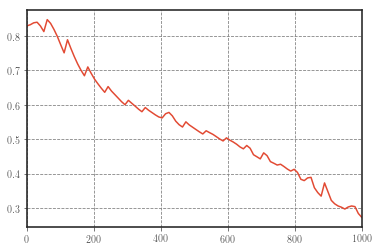

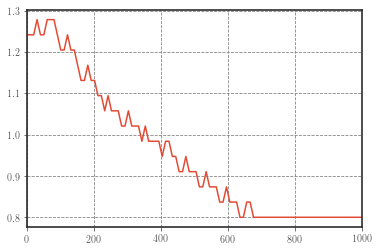

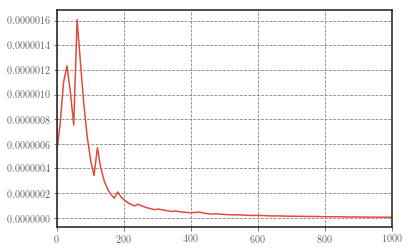

In [17]:
plot_performance(alpha_values, pvpd_list, metric="fill_factor")
plot_performance(alpha_values, pvpd_list, metric="V_at_max_P")
plot_performance(alpha_values, pvpd_list, metric="P_max")

In [8]:
alpha_values, pvpd_list = photovoltaic_performance_phonons(label='T300', num_alpha=50, num_voltages=20, 
                                                valence_energy=100e-3, binding_energy=100e-3, 
                                                radiative_lifetime=1, mu=700e-3, 
                                                N_max=17, T_C=300.)

[5, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17]
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 23.8 seconds
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 29.9 seconds
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 31.7 seconds
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 31.2 seconds
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 31.1 seconds
Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=6.
C-V data calculated in 44.7 seconds
Phonon occupation: 0.17. Phonon thermal 

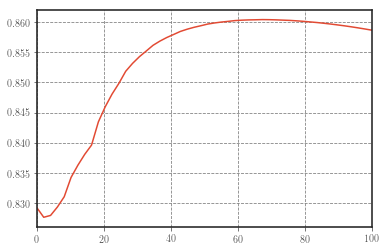

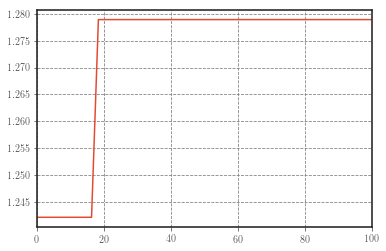

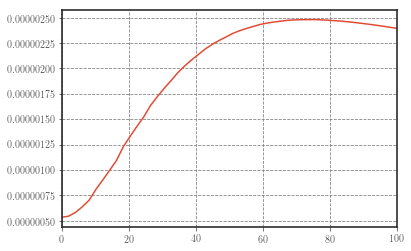

In [9]:
plot_performance(alpha_values, pvpd_list, metric="fill_factor")
plot_performance(alpha_values, pvpd_list, metric="V_at_max_P")
plot_performance(alpha_values, pvpd_list, metric="P_max")

In [10]:
alpha_values_200K, pvpd_list_200K = photovoltaic_performance_phonons(label='T200', num_alpha=50, num_voltages=20, 
                                                valence_energy=100e-3, binding_energy=100e-3, 
                                                radiative_lifetime=1, mu=700e-3, 
                                                N_max=13, T_C=200.)

[5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13]
Phonon occupation: 0.06. Phonon thermal energy is 139.00. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 22.2 seconds
Phonon occupation: 0.06. Phonon thermal energy is 139.00. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 28.2 seconds
Phonon occupation: 0.06. Phonon thermal energy is 139.00. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 28.2 seconds
Phonon occupation: 0.06. Phonon thermal energy is 139.00. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 28.2 seconds
Phonon occupation: 0.06. Phonon thermal energy is 139.00. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 28.2 seconds
Phonon occupation: 0.06. Phonon thermal energy is 139.00. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 28.2 seconds
Phonon occupation: 0.06. Phonon thermal energy is 

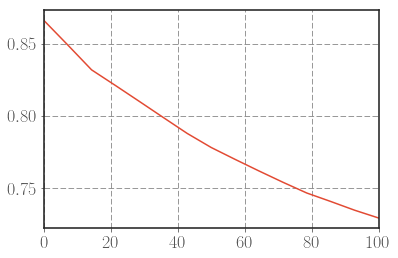

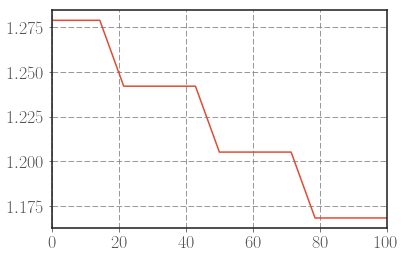

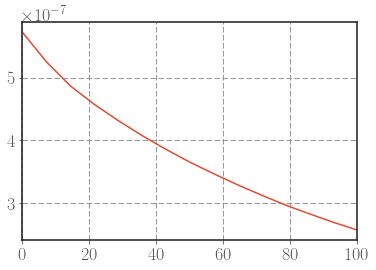

In [34]:
plot_performance(alpha_values_200K, pvpd_list_200K, metric="fill_factor")
plot_performance(alpha_values_200K, pvpd_list_200K, metric="V_at_max_P")
plot_performance(alpha_values_200K, pvpd_list_200K, metric="P_max")

In [11]:
alpha_values_100K, pvpd_list_100K = photovoltaic_performance_phonons(label='T200', num_alpha=50, num_voltages=20, 
                                                valence_energy=100e-3, binding_energy=100e-3, 
                                                radiative_lifetime=1, mu=700e-3, 
                                                N_max=13, T_C=100.)

[5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13]
Phonon occupation: 0.00. Phonon thermal energy is 69.50. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 22.2 seconds
Phonon occupation: 0.00. Phonon thermal energy is 69.50. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 28.2 seconds
Phonon occupation: 0.00. Phonon thermal energy is 69.50. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 29.0 seconds
Phonon occupation: 0.00. Phonon thermal energy is 69.50. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 28.3 seconds
Phonon occupation: 0.00. Phonon thermal energy is 69.50. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 28.2 seconds
Phonon occupation: 0.00. Phonon thermal energy is 69.50. Phonon SD peak is 0.00. V=0.0. N=5.
C-V data calculated in 28.2 seconds
Phonon occupation: 0.00. Phonon thermal energy is 69.50.

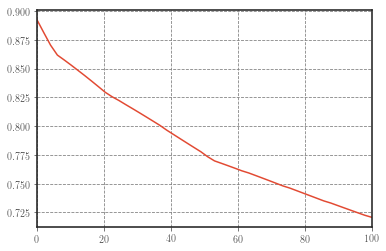

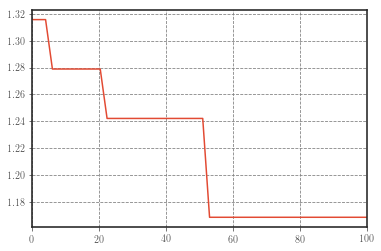

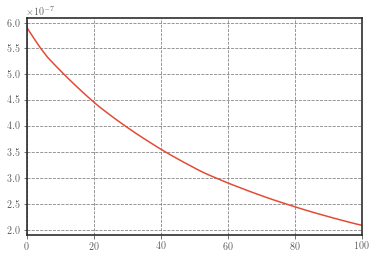

In [13]:
plot_performance(alpha_values_100K, pvpd_list_100K, metric="fill_factor")
plot_performance(alpha_values_100K, pvpd_list_100K, metric="V_at_max_P")
plot_performance(alpha_values_100K, pvpd_list_100K, metric="P_max")

# Data for each theory (additive leads, non-additive, etc)

In [5]:
def populations_and_current_vs_voltage_all(PARAMS, x_range=[0.,2.], num_voltages=100, label=''):
    
    if PARAMS['T_L']<100:
        number_of_voltages = int(1.8*num_voltages)
    else:
        number_of_voltages = num_voltages
    bias_voltages = np.concatenate((np.array([0]), 
                                    np.linspace(x_range[0]*ev_to_inv_cm, x_range[1]*ev_to_inv_cm, number_of_voltages)), 
                                   axis=0)
    labels = zip(["L_R", "L_R", "L_R_add", "L_R_add"], # Right lead 
                 ["L", "L_add_EM", "L_add_leads", "L_add"]) #and full dissipators (for current)
    data_dict = {} # inner dicts are of current and population data etc.
    for theory in labels:
        ti = time.time()
        current = []
        conduction_population = []
        valence_population = []
        ground_population = []
        hole_population = []
        electron_population = []
        exciton_population = []
        CC_population = []
        ops = make_expectation_operators(PARAMS)
        for i, bv in enumerate(bias_voltages):
            PARAMS.update({'mu_R': PARAMS['mu']+bv/2, 'mu_L': PARAMS['mu']-bv/2})
            #if i in [10, 90]:
            #    print_PARAMS(PARAMS)
            L_Lindblad_dict = build_L(PARAMS, silent=True)
            #ops = make_expectation_operators(PARAMS)
            n_c = tensor(d_e.dag()*d_e, qeye(PARAMS['N']))
            n_v = tensor(d_h.dag()*d_h, qeye(PARAMS['N']))
            ss = steadystate(L_Lindblad_dict['H_S'], [L_Lindblad_dict[theory[1]]])
            current.append(current_from_ss(ss, L_Lindblad_dict[theory[0]], n_c))
            conduction_population.append((n_c*ss).tr())
            valence_population.append((n_v*ss).tr())
            ground_population.append((ops['vac']*ss).tr())
            hole_population.append((ops['hole']*ss).tr())
            electron_population.append((ops['electron']*ss).tr())
            exciton_population.append((ops['exciton']*ss).tr())
            CC_population.append((ops['CC_pop']*ss).tr())
        data_dict[theory[1]] = {'bias_voltages':bias_voltages/ev_to_inv_cm, 
                     'current': current,
                     'conduction_population' : conduction_population, 
                     'valence_population' : valence_population,
                     'ground_population': ground_population,
                     'hole_population' : hole_population,
                     'electron_population' : electron_population,
                     'exciton_population' : exciton_population,
                     'CC_population' : CC_population,
                    'PARAMS': PARAMS}
        print("C-V {} calculated in {:0.1f} seconds".format(theory[1], time.time() - ti))
    save_obj(data_dict, "DATA/pvp/all_"+label)
    return data_dict

In [11]:
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.1, radiative_lifetime=1, alpha_ph=0.1e-3,
                      mu=700e-3, bias_voltage=0, N=4, silent=False, T_C=300.)

data_dict_test_0 = populations_and_current_vs_voltage_all(PARAMS, x_range=[0.8, 1.5], num_voltages=15, label='')

Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=4.
C-V L calculated in 15.8 seconds
C-V L_add_EM calculated in 16.9 seconds
C-V L_add_leads calculated in 16.4 seconds
C-V L_add calculated in 14.6 seconds


In [12]:
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.1, radiative_lifetime=1, alpha_ph=100e-3,
                      mu=700e-3, bias_voltage=0, N=13, silent=False, T_C=300.)

data_dict_test_1 = populations_and_current_vs_voltage_all(PARAMS, x_range=[0.8, 1.5], num_voltages=15)

Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=13.
C-V L calculated in 268.3 seconds
C-V L_add_EM calculated in 263.5 seconds
C-V L_add_leads calculated in 250.8 seconds
C-V L_add calculated in 258.4 seconds


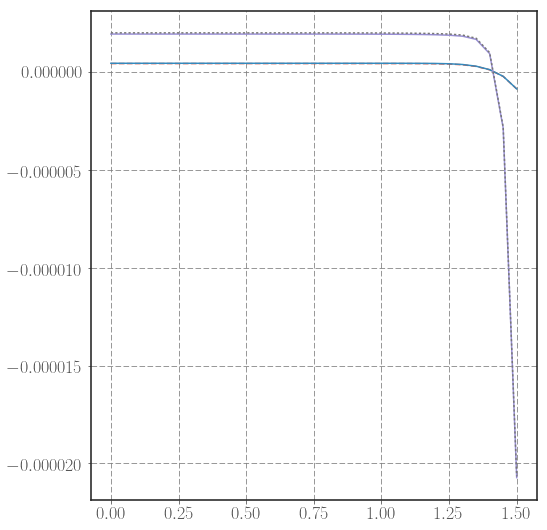

In [13]:
lab_dict = {'L': 'full', 'L_add_EM': 'add. EM', 'L_add_leads': 'add. Leads', 'L_add': 'add.'}
plt.figure(figsize=(8,9))
plt.plot(data_dict_test_1['L_add_leads']['bias_voltages'], data_dict_test_1['L_add_leads']['current'], 
         linestyle='dashed')
plt.plot(data_dict_test_0['L']['bias_voltages'], data_dict_test_0['L']['current'])
plt.plot(data_dict_test_1['L']['bias_voltages'], data_dict_test_1['L']['current'])
plt.plot(data_dict_test_1['L_add_EM']['bias_voltages'], data_dict_test_1['L_add_EM']['current'],
        linestyle='dotted')
#for lab, data in data_dict_test_1.items():
#    plt.plot(data['bias_voltages'], data['current'], label=lab_dict[lab])
#plt.legend()

In [14]:
get_photovoltaic_summary(data_dict_test_1['L'])

{'I_SC': 1.946174886278277e-06,
 'P_max': 2.387027687227405e-06,
 'P_theoretical_max': 2.7246448407895878e-06,
 'V_OC': 1.4000000000000001,
 'V_at_max_P': 1.3000000000000003,
 'fill_factor': 0.876087646908012}

In [15]:
get_photovoltaic_summary(data_dict_test_0['L'])

{'I_SC': 4.51906265080723e-07,
 'P_max': 5.3350636032662315e-07,
 'P_theoretical_max': 6.326687711130123e-07,
 'V_OC': 1.4000000000000001,
 'V_at_max_P': 1.25,
 'fill_factor': 0.84326330725643484}